In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

from spsim import prepare_simulation

## cluster config specific to SCARF
can be easily adapted to other queueing systems, see [dask-jobqueue](https://jobqueue.dask.org/en/latest/configuration-setup.html) docs for details

In [2]:
SCARF_GPU_CONFIG = {
    'queue': 'gpu',
    'cores': 1,
    'memory': '32GB',
    'job_extra': ['--gres=gpu:1']
}

# create a cluster
cluster = SLURMCluster(**SCARF_GPU_CONFIG)
client = Client(cluster)

## first experiment 1 GPU

In [3]:
cluster.scale(1)

In [9]:
cluster

SLURMCluster(ccafeabd, 'tcp://130.246.138.110:43704', workers=1, threads=1, memory=29.80 GiB)

create a `Simulation` object using `prepare_simulation`

In [11]:
simulation = prepare_simulation(
    input_directory='test_data/trajectory',
    output_basename='1gpu_test',
    n_images=10,
    image_sidelength=512,
    defocus_range=(0.5, 4),
)

In [12]:
t0 = datetime.now()
particle_stack = simulation.execute()
t1 = datetime.now()
dt = t1 - t0

In [13]:
print(f'{dt.total_seconds() / 10}s per particle (1 GPU)')

11.7820877s per particle (1 GPU)


## Can we throw more GPUs at it? (yes!)
easily scale from 10 particles, 1 GPU to 100 particles, 10 GPUs to see how computation scales...

In [14]:
simulation = prepare_simulation(
    input_directory='test_data/trajectory',
    output_basename='10gpu_test',
    n_images=100,
    image_sidelength=512,
    defocus_range=(0.5, 4),
)

In [15]:
cluster.scale(10)

In [17]:
cluster

SLURMCluster(ccafeabd, 'tcp://130.246.138.110:43704', workers=10, threads=10, memory=298.00 GiB)

In [18]:
t0 = datetime.now()
particle_stack = simulation.execute()
t1 = datetime.now()
dt = t1 - t0

In [20]:
print(f'{dt.total_seconds() / 100}s per particle (10 GPUs)')

2.3997664s per particle (10 GPUs)


~5x speedup for 10x increase in computational power

## quick look at the results
- the dask array returned provides the same interface as a numpy array
- dask array is a wrapper around a bunch of smaller numpy arrays distributed across our cluster
- saved to disk as a zarr file

In [27]:
particle_stack

dask.array<stack, shape=(100, 512, 512), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>

visualise first 10 particles...

(shouldn't do this on the head node really)

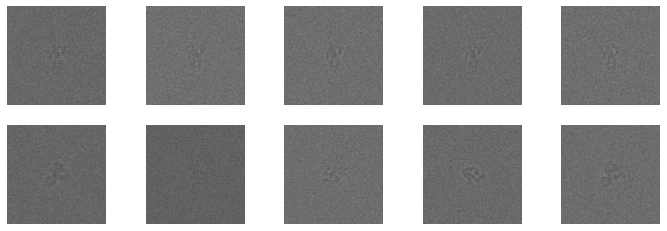

In [29]:
nr, nc = 2, 5
fig, axs = plt.subplots(nr, nc, figsize=(12, 4))
for i in range(nr):
    for j in range(nc):
        idx = (i * j) + i
        axs[i][j].imshow(particle_stack[idx], cmap='gray')
        axs[i][j].set_axis_off()


particles saved in a [zarr file](https://zarr.readthedocs.io/en/stable/) because dask interfaces nicely with it.
Need to figure out best way to generate large `.mrcs` with `mrcfile` (or not? zarr will be better for ML folks, parallel read)

In [32]:
ls *.zarr

10gpu_test.zarr:
0.0.0   18.0.0  27.0.0  36.0.0  45.0.0  54.0.0  63.0.0  72.0.0  81.0.0  90.0.0
1.0.0   19.0.0  28.0.0  37.0.0  46.0.0  55.0.0  64.0.0  73.0.0  82.0.0  91.0.0
10.0.0  2.0.0   29.0.0  38.0.0  47.0.0  56.0.0  65.0.0  74.0.0  83.0.0  92.0.0
11.0.0  20.0.0  3.0.0   39.0.0  48.0.0  57.0.0  66.0.0  75.0.0  84.0.0  93.0.0
12.0.0  21.0.0  30.0.0  4.0.0   49.0.0  58.0.0  67.0.0  76.0.0  85.0.0  94.0.0
13.0.0  22.0.0  31.0.0  40.0.0  5.0.0   59.0.0  68.0.0  77.0.0  86.0.0  95.0.0
14.0.0  23.0.0  32.0.0  41.0.0  50.0.0  6.0.0   69.0.0  78.0.0  87.0.0  96.0.0
15.0.0  24.0.0  33.0.0  42.0.0  51.0.0  60.0.0  7.0.0   79.0.0  88.0.0  97.0.0
16.0.0  25.0.0  34.0.0  43.0.0  52.0.0  61.0.0  70.0.0  8.0.0   89.0.0  98.0.0
17.0.0  26.0.0  35.0.0  44.0.0  53.0.0  62.0.0  71.0.0  80.0.0  9.0.0   99.0.0

1gpu_test.zarr:
0.0.0  1.0.0  2.0.0  3.0.0  4.0.0  5.0.0  6.0.0  7.0.0  8.0.0  9.0.0
